In [3]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

In [4]:
look_back = 7
epochs = 100
batch_size = 32

In [5]:
np.random.seed(7)

# read all prices using panda
prices_dataset =  pd.read_csv('prices-split-adjusted.csv', header=0)

# filter out only data of Apple
apple = prices_dataset[prices_dataset['symbol']=='AAPL']

# save Apple's stock values as type of floating point number
apple_stock_prices = apple.close.values.astype('float32')

In [14]:
apple_stock_prices

array([[ 30.572857],
       [ 30.625713],
       [ 30.13857 ],
       ...,
       [116.76    ],
       [116.73    ],
       [115.82    ]], dtype=float32)

In [15]:
apple

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0
2593,2010-01-11,AAPL,30.400000,30.015715,29.778572,30.428572,115557400.0
3061,2010-01-12,AAPL,29.884285,29.674286,29.488571,29.967142,148614900.0
3529,2010-01-13,AAPL,29.695715,30.092857,29.157143,30.132856,151473000.0
3997,2010-01-14,AAPL,30.015715,29.918571,29.860001,30.065714,108223500.0
4465,2010-01-15,AAPL,30.132856,29.418571,29.410000,30.228571,148516900.0


In [16]:
apple_stock_prices = apple_stock_prices.reshape(len(apple_stock_prices), 1)



In [17]:
apple_stock_prices

array([[ 30.572857],
       [ 30.625713],
       [ 30.13857 ],
       ...,
       [116.76    ],
       [116.73    ],
       [115.82    ]], dtype=float32)

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
apple_stock_prices = scaler.fit_transform(apple_stock_prices)

In [19]:
apple_stock_prices

array([[0.02971783],
       [0.03021854],
       [0.02560389],
       ...,
       [0.8461602 ],
       [0.845876  ],
       [0.8372556 ]], dtype=float32)

In [20]:
apple_stock_prices.shape

(1762, 1)

In [21]:
train_size = int(len(apple_stock_prices) * 0.67)
test_size = len(apple_stock_prices) - train_size
train, test = apple_stock_prices[0:train_size,:], apple_stock_prices[train_size:len(apple_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 1180 582


In [22]:
apple_stock_prices[0:train_size,:]

array([[0.02971783],
       [0.03021854],
       [0.02560389],
       ...,
       [0.6718587 ],
       [0.66835374],
       [0.6968672 ]], dtype=float32)

In [23]:
apple_stock_prices[train_size:len(apple_stock_prices),:]

array([[0.70094055],
       [0.70311934],
       [0.7028351 ],
       [0.695541  ],
       [0.7023615 ],
       [0.7043508 ],
       [0.69648826],
       [0.69743556],
       [0.71240276],
       [0.70397186],
       [0.667217  ],
       [0.69449896],
       [0.6884363 ],
       [0.69449896],
       [0.6796265 ],
       [0.686447  ],
       [0.6837946 ],
       [0.6837946 ],
       [0.67555314],
       [0.69497263],
       [0.69705665],
       [0.69430953],
       [0.68559444],
       [0.67555314],
       [0.664091  ],
       [0.6519657 ],
       [0.6653224 ],
       [0.6851208 ],
       [0.71079236],
       [0.71571827],
       [0.73314846],
       [0.7368429 ],
       [0.7358008 ],
       [0.7512417 ],
       [0.75692534],
       [0.7535151 ],
       [0.7631775 ],
       [0.77643955],
       [0.7688612 ],
       [0.77132416],
       [0.76980853],
       [0.77274513],
       [0.7710401 ],
       [0.7792814 ],
       [0.7939644 ],
       [0.80883694],
       [0.82172   ],
       [0.819

In [35]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
        
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY) 

# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [48]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

In [49]:
look_back

7

In [51]:
trainX.shape

(1172, 7, 1)

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size)

Train on 1172 samples
Epoch 1/100
1172/1172 [==============================] - 2s 2ms/sample - loss: 0.1151
Epoch 2/100
1172/1172 [==============================] - 0s 163us/sample - loss: 0.0556
Epoch 3/100
1172/1172 [==============================] - 0s 160us/sample - loss: 0.0243
Epoch 4/100
1172/1172 [==============================] - 0s 158us/sample - loss: 0.0142
Epoch 5/100
1172/1172 [==============================] - 0s 162us/sample - loss: 0.0116
Epoch 6/100
1172/1172 [==============================] - 0s 161us/sample - loss: 0.0096
Epoch 7/100
1172/1172 [==============================] - 0s 159us/sample - loss: 0.0077
Epoch 8/100
1172/1172 [==============================] - 0s 160us/sample - loss: 0.0059
Epoch 9/100
1172/1172 [==============================] - 0s 182us/sample - loss: 0.0043
Epoch 10/100
1172/1172 [==============================] - 0s 178us/sample - loss: 0.0030
Epoch 11/100
1172/1172 [==============================] - 0s 161us/sample - loss: 0.0020
Epoch 12/1

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [19]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.80 RMSE
Test Score: 6.88 RMSE


In [21]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(apple_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(apple_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(apple_stock_prices)-1, :] = testPredict

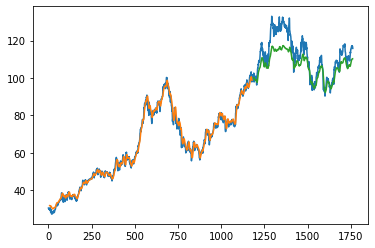

In [22]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(apple_stock_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()